In [1]:
## LSTM - WindMills - multi-step model
'''В этом случае на основе некой имеющейся истории модель обучается прогнозированию интервала будущих значений. 
Таким образом, в отличие модели, прогнозирующей только на одно значение в будущее, 
данная модель прогнозирует последовательность значений в будущем.
https://habr.com/ru/post/495884/'''

'В этом случае на основе некой имеющейся истории модель обучается прогнозированию интервала будущих значений. \nТаким образом, в отличие модели, прогнозирующей только на одно значение в будущее, \nданная модель прогнозирует последовательность значений в будущем.'

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Importing the dataset
wme = pd.read_csv('WindMills.csv')
wma = pd.read_csv('WindMillsActual.csv')
wm = pd.merge(wma, wme, on='Time')

C:\Users\kater\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3,12,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
wma

,Time,Wind_direction,Temperature,Pressure,Humidity
0,1/1/2016 0:00,101.0,1.3,885.9,65.4
1,1/1/2016 0:15,98.1,1.3,885.7,67.2
2,1/1/2016 0:30,99.8,1.2,885.6,68.1
3,1/1/2016 0:45,102.4,1.2,885.5,68.8
4,1/1/2016 1:00,102.8,1.2,885.3,70.1
...,...,...,...,...,...
70172,12/31/2017 23:00,63.4,2.1,885.5,45.2
70173,12/31/2017 23:15,75.9,2.0,885.3,45.5
70174,12/31/2017 23:30,69.4,2.1,885.3,45.8
70175,12/31/2017 23:45,72.9,2.0,885.2,46.2


In [4]:
# Checking missing
total = wma.isnull().sum().sort_values(ascending=False)
percent = (wma.isnull().sum()/wma.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
Wind_direction,33067,0.471194
Humidity,33050,0.470952
Pressure,33007,0.470339
Temperature,33004,0.470297
Time,0,0.000000


In [3]:
wma = wma.dropna()

In [4]:
# Features 
features_considered = ['Wind_direction','Temperature','Humidity']
features = wma[features_considered]
features.index = wma['Time']
features.head()

,Wind_direction,Temperature,Humidity
Time,,,
1/1/2016 0:00,101.0,1.3,65.4
1/1/2016 0:15,98.1,1.3,67.2
1/1/2016 0:30,99.8,1.2,68.1
1/1/2016 0:45,102.4,1.2,68.8
1/1/2016 1:00,102.8,1.2,70.1


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000029269286AC8>,
      dtype=object)

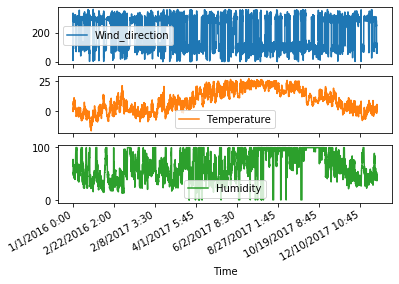

In [7]:
# Plotting data
features.plot(subplots=True)

In [5]:
'''Подготовим данные для модели с многомерным входом.'''
dataset = features.values

'''Первые 30 000 строк данных будут использоваться для обучения модели, оставшиеся – для её валидации (проверки). 
В этом случае объём обучающих данных составляет примерно 313 дней.'''
# Splitting dataset
TRAIN_SPLIT = 30000
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

'''Стандартизация должна выполняться только c использованием обучающих данных.'''
dataset = (dataset-data_mean)/data_std

In [6]:
'''Приведенная функция выполняет задачу организации временных интервалов, отбирая последние наблюдения 
на основе заданного размера шага.'''
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [7]:
'''ИНС оперирует данными за последние пять (3) дней, то есть 288 наблюдениями (4х24х3). 
Допустим, что отбор данных проводится не каждые 15 минут, а каждый час: 
в течение 60 минут резкие изменения не ожидаются. 
Следовательно, историю последних пяти дней составляют 120 наблюдений (480/4). 

В данном случае модель необходимо обучить прогнозировать температуру на следующие 3 часа. 
Поскольку наблюдения регистрируются каждые 15 минут, выход (output) модели должен состоять из 12 (3х4) прогнозов.'''
# Creating lagged dataset
past_history = 288
future_target = 12
STEP = 4

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [8]:
'''Проверим выборку'''
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (72, 3)

 Target temperature to predict : (12,)


In [9]:
# Importing the Tensorflow libraries and packages
import tensorflow as tf
#from tf.data import Dataset

# Importing the Keras libraries and packages
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

C:\Users\kater\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kater\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kater\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\kater\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [10]:
'''C помощью tf.data выполним перемешивание (shuffle), пакетирование (batch) и кэширование (cache) набора данных.'''
# Data preprocessing
BATCH_SIZE = 64
BUFFER_SIZE = 100

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [11]:
def create_time_steps(length):
  return list(range(-length, 0))

In [12]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

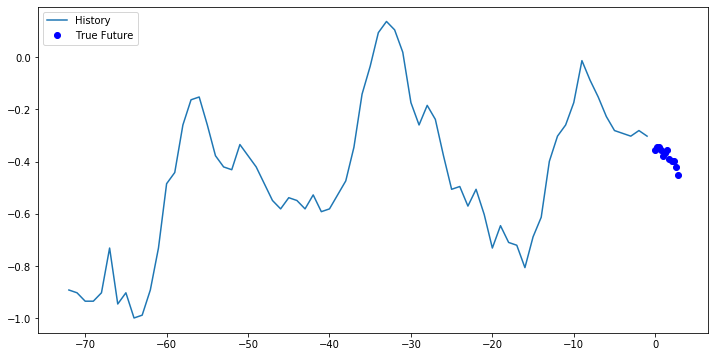

In [13]:
multi_step_plot(x_train_multi[0], y_train_multi[0], np.array([0]))

In [15]:
# LSTM creating
'''Так как интервальное прогнозирование сложнее, чем точечное, модель будет состоять из двух слоёв LSTM. 
Поскольку выполняется 12 прогноза, выход слой насчитывает 12 нейрона.'''
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(8,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(4, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(12))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [16]:
'''Проверим выборку'''
multi_step_model.predict(val_data_multi.take(1)).shape

(64, 12)

In [17]:
'''Обучим модель и  выведем кривые потерь на этапах обучения и проверки'''
# Fitting
EVALUATION_INTERVAL = 50
EPOCHS = 10
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
50/50 [==============================] - 9s 188ms/step - loss: 1.1570 - val_loss: 0.3956
Epoch 2/10
50/50 [==============================] - 7s 140ms/step - loss: 0.5694 - val_loss: 0.3944
Epoch 3/10
50/50 [==============================] - 7s 132ms/step - loss: 0.6515 - val_loss: 0.4015
Epoch 4/10
50/50 [==============================] - 7s 136ms/step - loss: 0.3952 - val_loss: 0.3939
Epoch 5/10
50/50 [==============================] - 7s 134ms/step - loss: 0.4513 - val_loss: 0.3506
Epoch 6/10
50/50 [==============================] - 7s 134ms/step - loss: 0.7874 - val_loss: 0.3384
Epoch 7/10
50/50 [==============================] - 7s 134ms/step - loss: 0.7986 - val_loss: 0.3805
Epoch 8/10
50/50 [==============================] - 7s 130ms/step - loss: 0.6110 - val_loss: 0.3577
Epoch 9/10
50/50 [==============================] - 7s 135ms/step - loss: 0.3845 - val_loss: 0.3457
Epoch 

In [18]:
# Plotting history function
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

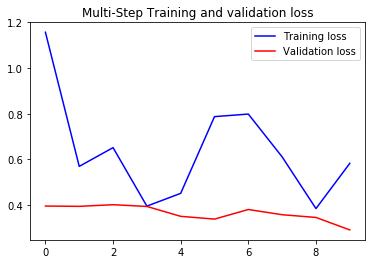

In [19]:
# Plotting history
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

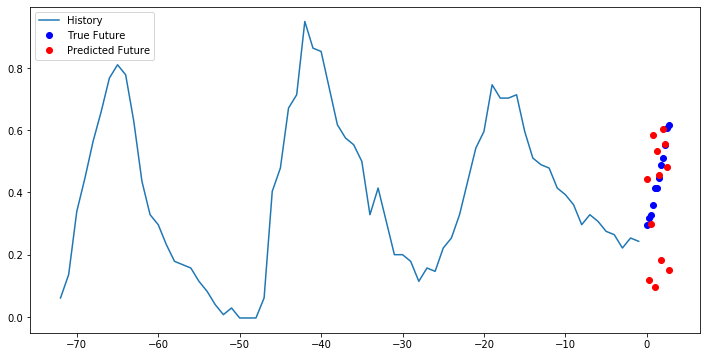

In [30]:
# LSTM Prediction plotting
multi_step_plot(x_val_multi[0], y_val_multi[0], multi_step_model.predict(val_data_multi.take(3))[0])